
# Edge Device Model Deployment

In this notebook, we will train a deep learning model and deploy it to the edge.

1. Train model using Keras
2. Convert to compressed floating point version using Tensorflow Lite
3. Deploy on Raspberry Pi or Edge Device

We will use this dataset, which is gathered from a smart factory in Germany: https://www.kaggle.com/inIT-OWL/versatileproductionsystem



In [1]:
# Use matching version of sklearn as Raspberry Pi docker container or edge device
!apt-get install python3.8

!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8

!update-alternatives --config python3

!apt install python3-pip

!apt-get install python3.8-distutils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib mailcap mime-support python3.8-minimal
Suggested packages:
  python3.8-venv binfmt-support
The following NEW packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib mailcap mime-support python3.8 python3.8-minimal
0 upgraded, 6 newly installed, 0 to remove and 33 not upgraded.
Need to get 5,098 kB of archives.
After this operation, 18.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.8-minimal amd64 3.8.18-1+jammy1 [794 kB]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.8-minimal am

In [2]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import sklearn
sklearn.__version__

'1.2.2'

In [3]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [4]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint

sns.set(style='whitegrid')
%matplotlib inline

## Dataset

Load the dataset from our github repository.

In [5]:
!curl https://raw.githubusercontent.com/lisaong/diec/master/data/versatileproductionsystem.zip --output data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  397k  100  397k    0     0   851k      0 --:--:-- --:--:-- --:--:--  849k


In [6]:
!unzip -o data.zip

Archive:  data.zip
  inflating: Filling_CapScrewer.module.csv  
  inflating: Filling_ALL.module.csv  
  inflating: Dosingmodule.csv        
  inflating: Filling_CornPortioning.module.csv  
  inflating: Filling_Pump.module.csv  
  inflating: Deliverymodule.csv      
  inflating: Filling_CapGrabber.module.csv  
  inflating: Production.csv          
  inflating: Storagemodule.csv       


In [7]:
# read one of the data files
df = pd.read_csv('./Filling_ALL.module.csv', index_col=0)
df.head()

,I_BottleAtAirpipe,I_BottleClampClose,I_BottleClampOpen,I_BottleGateClosed,I_BottleReserveGateClosed,I_BottlesAvailable,I_BottleSlot1,I_BottleSlot2_H2O,I_BottleSlot3_Corn,I_BottleSlot5_CapOn,...,BottlesAvailable.AnalogValue.EURangeViolation,BottleSlot1.AnalogValue.EURangeViolation,BottleSlot2_H2O.AnalogValue.EURangeViolation,BottleSlot3_Corn.AnalogValue.EURangeViolation,BottleSlot5_CapOn.AnalogValue.EURangeViolation,BottleSlot6_CapCloser.AnalogValue.EURangeViolation,BottleSlot8_ModuleOut.AnalogValue.EURangeViolation,BottlesNotUsed.AnalogValue.EURangeViolation,UltraSonic_Corn.DistanceM.EURangeViolation,UltraSonic_H2O.DistanceM.EURangeViolation
Timestamp,,,,,,,,,,,,,,,,,,,,,
1529500027127,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027227,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027327,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027428,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027528,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Task Definition

A common factory monitoring scenario is to predict a target based on past history.

For the purposes of this workshop, let's try to predict the value of 'I_BottlesReserveAvailable', using last 10 values of each feature.

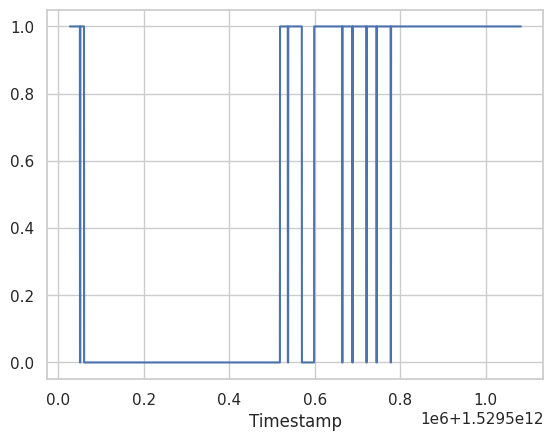

In [8]:
# Target
target = 'I_BottlesReserveAvailable'

df[target].plot();

In [9]:
# check for balanced classes
df[target].value_counts()

1    5603
0    4926
Name: I_BottlesReserveAvailable, dtype: int64

In [10]:
# drop some columns that the target is derived from (otherwise we are cheating)
df.drop(['BottlesAvailable', 'BottlesNotUsed', 'I_BottleStorageFull'], axis=1, inplace=True)
df.columns

Index(['I_BottleAtAirpipe', 'I_BottleClampClose', 'I_BottleClampOpen',
       'I_BottleGateClosed', 'I_BottleReserveGateClosed', 'I_BottlesAvailable',
       'I_BottleSlot1', 'I_BottleSlot2_H2O', 'I_BottleSlot3_Corn',
       'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_BottleSlot8_Output', 'I_BottlesReserveAvailable', 'I_CapGrabberDown',
       'I_CapGrabberUp', 'I_CapOnConveyor', 'I_CapScrewer_Down',
       'I_CapScrewer_Up', 'I_CapScrewerClosePos', 'I_CapScrewerGrabClosed',
       'I_CapScrewerOpenPos', 'I_CornTankFull', 'I_LinAxisCapInGrabber',
       'I_LinAxisDown', 'I_LinAxisEmptyGrabber', 'I_LinAxisUp',
       'I_NoCapOnConveyor', 'I_Portioning', 'I_Pump_Down', 'I_Pump_Up',
       'I_RotaryTablePosReached', 'I_UltrasonicCorn',
       'I_UltrasonicCorn_Distance', 'I_UltrasonicH2O',
       'I_UltrasonicH2O_Distance', 'I_WaterTankMinFull', 'I_WaterTankNotFull',
       'O_ActivateAirpipe', 'O_BottleClampClose', 'O_CapGrabberOpenClose',
       'O_CapGrabberUpDown', 'O

## Reserve for testing

Reserve the some values for testing on the Raspberry Pi or Edge Device.


In [11]:
test_size = 100

df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]

df_train.shape, df_test.shape

((10429, 81), (100, 81))

In [12]:
# save input numpy arrays for later use
pickle.dump(df_train.loc[:, df_train.columns != target].values,
            open('./X_train.pkl', 'wb'))

pickle.dump(df_test.loc[:, df_test.columns != target].values,
            open('./X_test.pkl', 'wb'))

## Feature Selection

First, some basic feature selection: Filter out columns that don't change very much (low variance).

In [13]:
# Candidate features

candidates = df_train.columns[df_train.columns != target]
candidates

Index(['I_BottleAtAirpipe', 'I_BottleClampClose', 'I_BottleClampOpen',
       'I_BottleGateClosed', 'I_BottleReserveGateClosed', 'I_BottlesAvailable',
       'I_BottleSlot1', 'I_BottleSlot2_H2O', 'I_BottleSlot3_Corn',
       'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_BottleSlot8_Output', 'I_CapGrabberDown', 'I_CapGrabberUp',
       'I_CapOnConveyor', 'I_CapScrewer_Down', 'I_CapScrewer_Up',
       'I_CapScrewerClosePos', 'I_CapScrewerGrabClosed', 'I_CapScrewerOpenPos',
       'I_CornTankFull', 'I_LinAxisCapInGrabber', 'I_LinAxisDown',
       'I_LinAxisEmptyGrabber', 'I_LinAxisUp', 'I_NoCapOnConveyor',
       'I_Portioning', 'I_Pump_Down', 'I_Pump_Up', 'I_RotaryTablePosReached',
       'I_UltrasonicCorn', 'I_UltrasonicCorn_Distance', 'I_UltrasonicH2O',
       'I_UltrasonicH2O_Distance', 'I_WaterTankMinFull', 'I_WaterTankNotFull',
       'O_ActivateAirpipe', 'O_BottleClampClose', 'O_CapGrabberOpenClose',
       'O_CapGrabberUpDown', 'O_CapScrewDown', 'O_CapScrewerGrabber

In [14]:
# Apply variance threshold of 0.1
vt = VarianceThreshold(threshold=0.1)
vt.fit(df_train[candidates])

# filtered out features
features = candidates[vt.get_support()]
features

Index(['I_BottleClampClose', 'I_BottleClampOpen', 'I_BottleSlot2_H2O',
       'I_BottleSlot3_Corn', 'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_CapGrabberUp', 'I_CapScrewer_Up', 'I_CapScrewerOpenPos',
       'I_LinAxisCapInGrabber', 'I_LinAxisDown', 'I_LinAxisEmptyGrabber',
       'I_Pump_Down', 'I_RotaryTablePosReached', 'I_UltrasonicCorn',
       'I_UltrasonicCorn_Distance', 'I_UltrasonicH2O_Distance',
       'O_BottleClampClose', 'O_CapGrabberOpenClose', 'O_CapGrabberUpDown',
       'O_CapScrewDown', 'O_CloseCap', 'O_ConveyorCapsForward',
       'O_LinAxisUpDown', 'O_RotaryTable', 'O_ValvePumpCloseOpen',
       'PendingOrder', 'Rotating', 'State', 'BottleSlot1', 'BottleSlot2_H2O',
       'BottleSlot3_Corn', 'BottleSlot5_CapOn', 'BottleSlot6_CapCloser',
       'BottleSlot8_ModuleOut', 'UltraSonic_Corn.DistanceM',
       'UltraSonic_H2O.DistanceM'],
      dtype='object')

## Scaling

Next, scale the features so that we can speed up training.

In [15]:
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
feature_values = feature_scaler.fit_transform(df_train[features])
feature_values

array([[-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.94641148,  1.        ],
       [-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.94449761,  1.        ],
       [-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.95215311,  1.        ],
       ...,
       [-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.99808612, -0.53684211],
       [-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.99808612, -0.53684211],
       [-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.99808612, -0.53684211]])

## Time Series Windowing

Next, convert the time series so that each entry contains a series of timesteps.

Before: rows, features

After: rows, timesteps, features

Note that some rows will be removed because we are taking a window of values.

In [16]:
timesteps = 10

print(feature_values.shape) # (rows, features)

rolling_indexes = [(range(i, i+timesteps))
                   for i in range(feature_values.shape[0]-timesteps)]

X_sequence = np.take(feature_values, rolling_indexes, axis=0)
X_sequence.shape # (rows, timesteps, features)

(10429, 37)


(10419, 10, 37)

In [17]:
# shift y down by 1 value so that we are predicting the future
# make sure y is the same length as X_sequence

# print(df[target].shape)
y = df[target][timesteps:X_sequence.shape[0]+timesteps].values
y.shape

(10419,)

## Train model

We will train a very simple 1D convolutional model to try to predict y from X_sequence.

To recap:

- X_sequence (rows, timesteps, features): each scaled feature at [t-9] ... [t]
- y (rows): target[t+1]

The convolutional 1D layer will look at windows of timesteps, one feature at a time. Here's a more detailed reference on it for time series data: https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/


Note: we can also train an LSTM model, but currently Tensorflow Lite with Keras does not support it nicely (yet): https://github.com/tensorflow/tensorflow/issues/30864

In [18]:
# create training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_sequence, y, test_size=0.1,
                                                  stratify=y)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((9377, 10, 37), (1042, 10, 37), (9377,), (1042,))

In [19]:
model = Sequential()

# input_shape=(timesteps, features)
model.add(Conv1D(64, kernel_size=3,
                 input_shape=(X_train.shape[1], X_train.shape[2]),
                 activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            7168      
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 64)                41024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 48257 (188.50 KB)
Trainable params: 48257 (188.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [21]:
mc = ModelCheckpoint('./cnn.h5', save_best_only=True)

In [22]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val), callbacks=[mc])

Epoch 1/20
294/294 [==============================] - 7s 8ms/step - loss: 0.2086 - acc: 0.9096 - val_loss: 0.1270 - val_acc: 0.9386
Epoch 2/20
 26/294 [=>............................] - ETA: 1s - loss: 0.1511 - acc: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


294/294 [==============================] - 2s 6ms/step - loss: 0.1141 - acc: 0.9522 - val_loss: 0.1172 - val_acc: 0.9511
Epoch 3/20
294/294 [==============================] - 1s 4ms/step - loss: 0.0955 - acc: 0.9582 - val_loss: 0.0754 - val_acc: 0.9559
Epoch 4/20
294/294 [==============================] - 1s 4ms/step - loss: 0.0866 - acc: 0.9622 - val_loss: 0.0802 - val_acc: 0.9731
Epoch 5/20
294/294 [==============================] - 1s 4ms/step - loss: 0.0718 - acc: 0.9688 - val_loss: 0.1076 - val_acc: 0.9568
Epoch 6/20
294/294 [==============================] - 2s 5ms/step - loss: 0.0618 - acc: 0.9722 - val_loss: 0.0590 - val_acc: 0.9750
Epoch 7/20
294/294 [==============================] - 1s 4ms/step - loss: 0.0538 - acc: 0.9749 - val_loss: 0.0530 - val_acc: 0.9731
Epoch 8/20
294/294 [==============================] - 1s 4ms/step - loss: 0.0487 - acc: 0.9785 - val_loss: 0.0904 - val_acc: 0.9664
Epoch 9/20
294/294 [==============================] - 1s 4ms/step - loss: 0.0468 - acc:

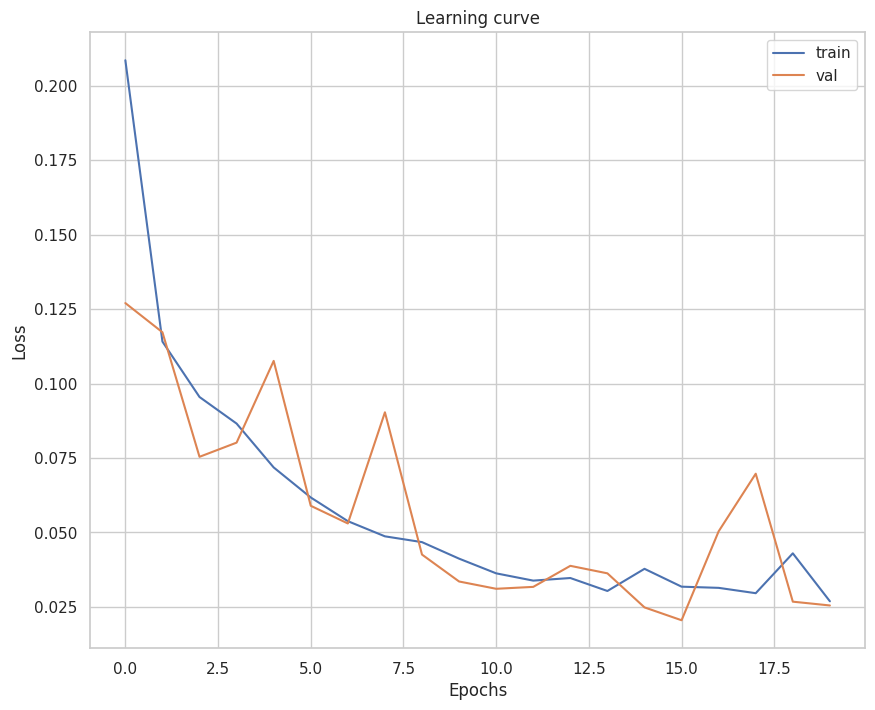

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')
ax.legend()
ax.set_title('Learning curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

### Predictions

We'll test the model by getting predictions for our test data.

The steps followed here will be repeated on the Raspberry Pi or Edge Device, so we want to make sure these are repeatable.

In [24]:
df_test_X = df_test.loc[:, df_test.columns != target]
df_test_y = df_test[[target]]

df_test_X.shape, df_test_y.shape

((100, 80), (100, 1))

In [25]:
# select features
test_X = vt.transform(df_test_X)

# scale
test_X_scaled = feature_scaler.transform(test_X)

# create windowed
rolling_indexes = [(range(i, i+timesteps))
                   for i in range(test_X_scaled.shape[0]-timesteps)]

test_X_sequence = np.take(test_X_scaled, rolling_indexes, axis=0)

print(test_X_sequence.shape) # (rows, timesteps, features)

(90, 10, 37)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [26]:
# shift y down by window values so that we are predicting the future
test_y = df_test_y[timesteps:]

# make sure y is the same number of rows as test_X_sequence
print(test_y.shape)

(90, 1)


In [27]:
# predict by loading the checkpointed model with the lowest validation loss
best_model = load_model('./cnn.h5')
# pred = best_model.predict_classes(test_X_sequence)
pred = (best_model.predict(test_X_sequence) > 0.5).astype('int32')

3/3 [==============================] - 0s 24ms/step


In [28]:
# score
print(classification_report(test_y, pred))
print(confusion_matrix(test_y, pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        90

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

[[90]]


In [29]:
# try to predict some class 0 values using validation set

# pred_val = model.predict_classes(X_val)
pred_val = (best_model.predict(X_val) > 0.5).astype('int32')

print(classification_report(y_val, pred_val))
print(confusion_matrix(y_val, pred_val))

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       493
           1       0.99      1.00      0.99       549

    accuracy                           0.99      1042
   macro avg       0.99      0.99      0.99      1042
weighted avg       0.99      0.99      0.99      1042

[[488   5]
 [  1 548]]


## Deployment

1. Save pre-processors
2. Convert to Tensorflow Lite: https://www.tensorflow.org/lite/convert#from_model_training_to_device_deployment

In [30]:
# Save preprocessors, create a dictionary so that everything in 1 place

preprocessors = {
    'variance_threshold' : vt,
    'feature_scaler' : feature_scaler
}

pickle.dump(preprocessors, open('./preprocessors.pkl', 'wb'))

In [31]:
# Convert to Tensorflow lite

# older version of TFLite
# converter = tf.lite.TFLiteConverter.from_keras_model_file('./cnn.h5')

# latest version of TFLite
saved_model = tf.keras.models.load_model('./cnn.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)

# https://www.tensorflow.org/api_docs/python/tf/lite/Optimize
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]

tflite_model = converter.convert()
with open('./cnn.tflite', 'wb') as f:
  f.write(tflite_model)

### Testing TensorFlow Lite Inference

https://www.tensorflow.org/lite/guide/inference#running_a_model

Before running inference on a Raspberry Pi or Edge Device, it is easier to write code and test out the inference on a PC or Google Cloud.

In [32]:
# This is the code we will run on the Raspberry Pi or Edge Device
import pickle
import numpy as np
import tensorflow as tf

def load_test_data(data_filename, preprocessors_filename):
  timesteps = 10

  # Load test data and process it
  test_array = pickle.load(open(data_filename, 'rb'))

  preprocessors = pickle.load(open(preprocessors_filename, 'rb'))
  vt = preprocessors['variance_threshold']
  feature_scaler = preprocessors['feature_scaler']

  # select features
  test_X = vt.transform(test_array)

  # scale
  test_X_scaled = feature_scaler.transform(test_X)

  # create windowed
  rolling_indexes = [(range(i, i+timesteps))
                     for i in range(test_X_scaled.shape[0]-timesteps)]

  test_X_sequence = np.take(test_X_scaled, rolling_indexes, axis=0)
  print(test_X_sequence.shape) # (rows, timesteps, features)

  return test_X_sequence

In [33]:
X_test = load_test_data('./X_test.pkl', './preprocessors.pkl')

(90, 10, 37)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [34]:
def predict(model_path, test_data):
  # Load TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Test model on input data.
  input_shape = input_details[0]['shape']

  # Loop through each row of test_data and perform inference
  for i in range(test_data.shape[0]):

    # add batch dimension
    input_data = np.expand_dims(test_data[i], axis=0).astype('float32')

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(output_data)

### Exercise 1: Testing the compressed model
<p>
<font color="red">
Update the cell below to get predictions from N randomly chosen samples, using the Tensorflow Lite version of the model.
</font>
</p>
<p>
<font color="green">
Submission:
<ol>
<li type='a'>Paste the updated code into the submission worksheet</li>
<li type='a'>Paste predictions into the submission worksheet</li>
</ol>
</font>
</p>

In [ ]:
# Exercise: test out your compressed tensorflow lite model to get
# predictions from randomly selected samples before deploying to the Edge device.
#
# Hint1: you may use the helper function above to get a prediction.
# Hint2: you may use the following code to get a random selection of samples
# N = <pick_a_number>
# random_index = np.random.choice(range(len(X_test)), N)
#

X_test = load_test_data('./X_test.pkl', './preprocessors.pkl')

#
# ADD YOUR CODE BELOW
#

(90, 10, 37)
